Sourced from https://m2lines.github.io/L96_demo/notebooks/intro_ML_and_NNs.html

In [2]:
from m_star_predictor import LinearRegression, FCNN, train_model, test_model, fit_model, simple_FCNN
import torch
import torch.utils.data as Data
from torch.utils.data import random_split
from torch import optim
import numpy as np
import os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(123);
sklear_random_state = 123

In [3]:
mean_vals = True

data_directory = '../m_star_dataset'
dataset_name = 'ePBL_paper_expanded_2283_corrected'
dataset_filename = f"{dataset_name}_mean_dataset_no_hf.pt" if mean_vals else f"{dataset_name}_dataset_no_hf.pt"
data = torch.load(os.path.join(data_directory, dataset_filename))

In [4]:
X, y = data.T[:,:-1].float(), data.T[:,-1].unsqueeze(1).float()

In [5]:
print(X.shape, y.shape)

torch.Size([360, 1]) torch.Size([360, 1])


In [6]:
BATCH_SIZE = 2 ** 4 if mean_vals else 2 ** 13

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=sklear_random_state
)

X_train_mean = X_train.mean(dim=0)
X_train_std = X_train.std(dim=0)
y_train_mean = y_train.mean(dim=0)
y_train_std = y_train.std(dim=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

train_dataset = Data.TensorDataset(X_train, y_train)
test_dataset = Data.TensorDataset(X_test, y_test)

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

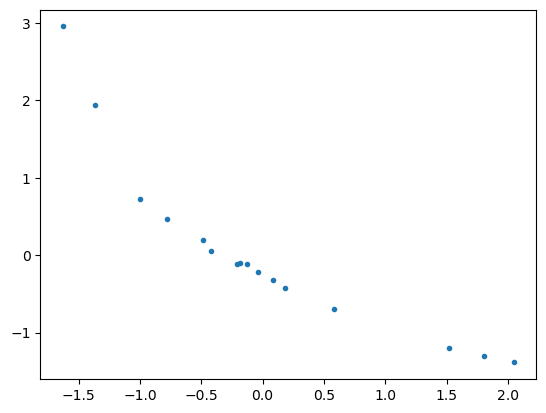

In [8]:
data_iterator = iter(train_loader)
X_iter, subgrid_tend_iter = next(data_iterator)

plt.plot(X_iter, subgrid_tend_iter, '.')

In [9]:
linear_network = LinearRegression()
fcnn_network = simple_FCNN()

In [10]:
loss_fn = torch.nn.MSELoss()

In [11]:
# Load the input and output pair from the data loader
X_tmp = next(iter(train_loader))

# Predict the output
y_tmp_linear = linear_network(torch.unsqueeze(X_tmp[0], 1))
y_tmp_fcnn = fcnn_network(torch.unsqueeze(X_tmp[0], 1))

# Calculate the MSE loss
loss_linear = loss_fn(y_tmp_linear, torch.unsqueeze(X_tmp[1], 1))
print(f"Linear network MSE Loss: {loss_linear.item():.4f}")

loss_fcnn = loss_fn(y_tmp_fcnn, torch.unsqueeze(X_tmp[1], 1))
print(f"FCNN MSE Loss: {loss_fcnn.item():.4f}")

Linear network MSE Loss: 0.8680
FCNN MSE Loss: 0.8969


In [12]:
learning_rate = 0.003
momentum = 0.1

In [13]:
optimizer_linear = optim.Adam(linear_network.parameters(), lr=learning_rate)
print("Before backward pass: \n", list(linear_network.parameters())[0].data.numpy())

loss_linear.backward(retain_graph=True)
optimizer_linear.step()

print("\nAfter backward pass: \n", list(linear_network.parameters())[0].data.numpy())

Before backward pass: 
 [[-0.8520551]]

After backward pass: 
 [[-0.8550551]]


In [14]:
optimizer_fcnn = optim.Adam(fcnn_network.parameters(), lr=learning_rate)

In [15]:
n_epochs = 300

In [16]:
train_loss_linear, test_loss_linear = fit_model(
    linear_network, loss_fn, optimizer_linear, train_loader, test_loader, n_epochs
)

epoch 1 completed
epoch 2 completed
epoch 3 completed
epoch 4 completed
epoch 5 completed
epoch 6 completed
epoch 7 completed
epoch 8 completed
epoch 9 completed
epoch 10 completed
epoch 11 completed
epoch 12 completed
epoch 13 completed
epoch 14 completed
epoch 15 completed
epoch 16 completed
epoch 17 completed
epoch 18 completed
epoch 19 completed
epoch 20 completed
epoch 21 completed
epoch 22 completed
epoch 23 completed
epoch 24 completed
epoch 25 completed
epoch 26 completed
epoch 27 completed
epoch 28 completed
epoch 29 completed
epoch 30 completed
epoch 31 completed
epoch 32 completed
epoch 33 completed
epoch 34 completed
epoch 35 completed
epoch 36 completed
epoch 37 completed
epoch 38 completed
epoch 39 completed
epoch 40 completed
epoch 41 completed
epoch 42 completed
epoch 43 completed
epoch 44 completed
epoch 45 completed
epoch 46 completed
epoch 47 completed
epoch 48 completed
epoch 49 completed
epoch 50 completed
epoch 51 completed
epoch 52 completed
epoch 53 completed
ep

In [19]:
train_loss_fcnn, test_loss_fcnn = fit_model(
    fcnn_network, loss_fn, optimizer_fcnn, train_loader, test_loader, n_epochs
)

epoch 1 completed
epoch 2 completed
epoch 3 completed
epoch 4 completed
epoch 5 completed
epoch 6 completed
epoch 7 completed
epoch 8 completed
epoch 9 completed
epoch 10 completed
epoch 11 completed
epoch 12 completed
epoch 13 completed
epoch 14 completed
epoch 15 completed
epoch 16 completed
epoch 17 completed
epoch 18 completed
epoch 19 completed
epoch 20 completed
epoch 21 completed
epoch 22 completed
epoch 23 completed
epoch 24 completed
epoch 25 completed
epoch 26 completed
epoch 27 completed
epoch 28 completed
epoch 29 completed
epoch 30 completed
epoch 31 completed
epoch 32 completed
epoch 33 completed
epoch 34 completed
epoch 35 completed
epoch 36 completed
epoch 37 completed
epoch 38 completed
epoch 39 completed
epoch 40 completed
epoch 41 completed
epoch 42 completed
epoch 43 completed
epoch 44 completed
epoch 45 completed
epoch 46 completed
epoch 47 completed
epoch 48 completed
epoch 49 completed
epoch 50 completed
epoch 51 completed
epoch 52 completed
epoch 53 completed
ep

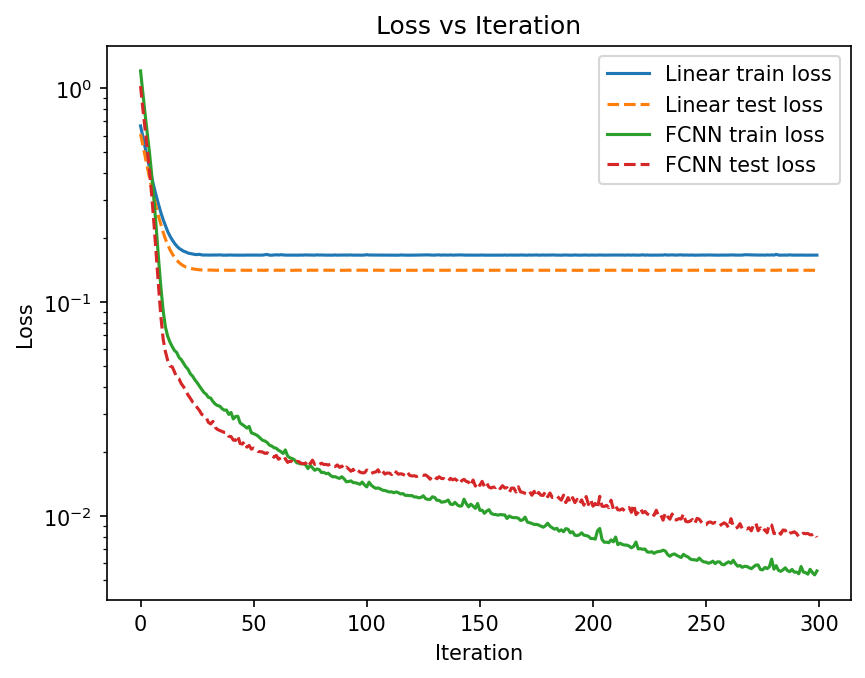

In [20]:
plt.figure(dpi=150)

plt.plot(train_loss_linear, label="Linear train loss")
plt.plot(test_loss_linear, linestyle="--", label="Linear test loss")

plt.plot(train_loss_fcnn, label="FCNN train loss")
plt.plot(test_loss_fcnn, linestyle="--", label="FCNN test loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();

In [18]:
# TODO: build function to plot true and predicted m* 

In [21]:
X_normalized = (X - X_train_mean) / X_train_std
fcnn_prediction = fcnn_network(X_normalized)*y_train_std+y_train_mean

In [22]:
xs = torch.linspace(0,1,10000)

In [23]:
xs_normalized = (xs.unsqueeze(1) - X_train_mean) / X_train_std
fcnn_prediction_curve = fcnn_network(xs_normalized)*y_train_std+y_train_mean

Text(0.5, 0, '$y_{pred}$')

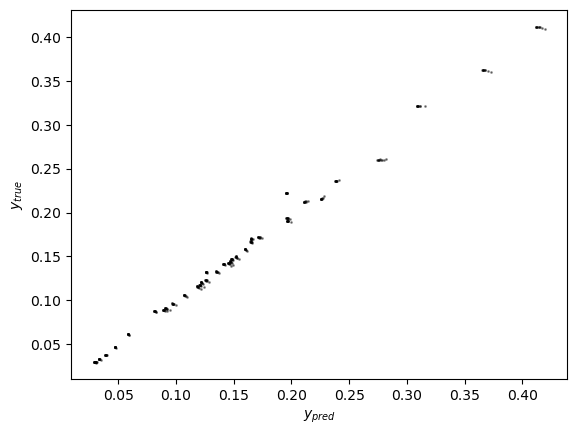

In [27]:
plt.scatter(fcnn_prediction.detach().numpy(), y, color="black", s=1, alpha=.4)
plt.ylabel("$y_{true}$")
plt.xlabel("$y_{pred}$")

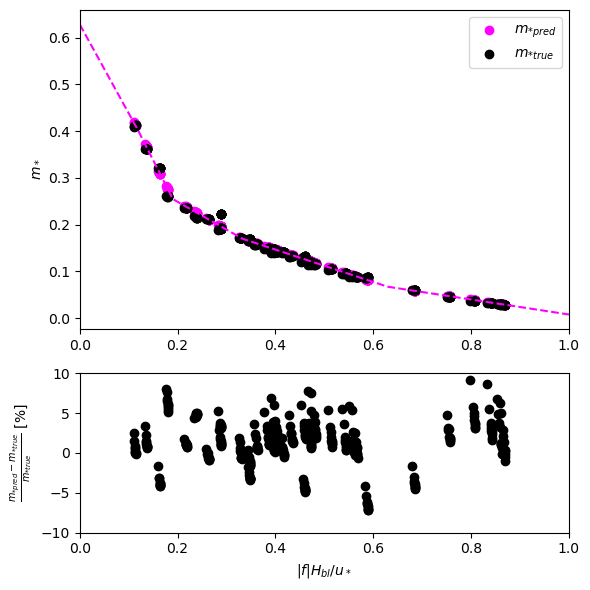

In [28]:
fig, ax = plt.subplots(2,1,figsize=(6,6), gridspec_kw={'height_ratios': [2,1]})

ax[0].scatter(X, fcnn_prediction.detach().numpy(), color="magenta", label="$m_{*pred}$")
ax[0].scatter(X, y, color="black", label="$m_{*true}$")
ax[0].plot(xs.detach().numpy(), fcnn_prediction_curve.detach().numpy(), color="magenta", linestyle="dashed")
ax[0].set_ylabel("$m_*$")
ax[0].set_xlim(-0., 1.)
ax[1].set_xlabel("$|f|H_{bl}/u_*$")
ax[0].legend()

ax[1].scatter(X, (fcnn_prediction.detach().numpy()-y.detach().numpy())/y.detach().numpy()*100, color="black")
ax[1].set_xlim(-0., 1.)
ax[1].set_ylim(-10., 10.)
ax[1].set_ylabel(r"$\frac{m_{*pred}-m_{*true}}{m_{*true}}$ [%]")

fig.tight_layout()
save = f"prediction_simple_fcnn_{dataset_name}_mean.png" if mean_vals else f"prediction_simple_fcnn_{dataset_name}.png"
plt.savefig(save, dpi=300)

In [30]:
np.sqrt(np.mean((fcnn_prediction.detach().numpy()-y.detach().numpy())**2))

0.0067093708

In [25]:
(fcnn_prediction.detach().numpy()-y.detach().numpy())**2

array([[6.58030040e-04],
       [4.16962394e-06],
       [1.53334440e-05],
       [1.30609763e-07],
       [7.22796947e-04],
       [1.19300112e-05],
       [2.86594332e-06],
       [4.18842683e-06],
       [7.36501475e-04],
       [1.52459861e-05],
       [1.52916778e-06],
       [8.52313588e-06],
       [7.84603835e-05],
       [4.75432807e-06],
       [2.95239306e-06],
       [6.18189006e-06],
       [1.52424955e-05],
       [2.13171534e-05],
       [6.27486043e-06],
       [1.76365916e-07],
       [1.06177995e-05],
       [2.66753341e-05],
       [1.03145821e-05],
       [1.69789246e-06],
       [6.94771006e-05],
       [3.43654610e-05],
       [2.11656516e-05],
       [3.19419378e-05],
       [4.69996439e-06],
       [7.44678300e-06],
       [1.71221325e-06],
       [7.95601451e-08],
       [1.55981593e-06],
       [4.62755952e-06],
       [3.11590114e-08],
       [1.02566253e-06],
       [5.50856457e-05],
       [1.09677756e-04],
       [3.56453638e-05],
       [5.59186810e-05],


In [38]:
(fcnn_prediction.detach().numpy()-y.detach().numpy())**2

array([[2.55994848e-04],
       [8.35995306e-05],
       [2.64995742e-05],
       [1.48081754e-05],
       [5.83639252e-04],
       [1.90813080e-04],
       [2.71833699e-07],
       [1.14368986e-05],
       [1.34974916e-03],
       [5.51225894e-05],
       [3.25948931e-05],
       [1.46597185e-05],
       [3.23253422e-04],
       [1.81625046e-06],
       [1.78920818e-05],
       [9.48226534e-06],
       [4.02205078e-05],
       [2.36432752e-05],
       [5.11790813e-06],
       [4.69805542e-07],
       [1.30537519e-04],
       [1.34690424e-06],
       [4.43528188e-06],
       [1.47145749e-06],
       [1.66235375e-04],
       [3.96297821e-07],
       [7.28135774e-06],
       [2.72795478e-06],
       [5.06907736e-06],
       [3.01947457e-05],
       [1.71845786e-05],
       [1.15127909e-06],
       [2.03754757e-06],
       [5.12278457e-05],
       [2.77501636e-06],
       [1.64426383e-05],
       [1.47925539e-05],
       [1.61384069e-05],
       [4.27056284e-06],
       [2.05490196e-05],
